# **Conformational Biasing! (CB)**
*Updated: 10/17/2025 by Andrew Xue*

<img src="https://raw.githubusercontent.com/alicetinglab/ConformationalBiasing/main/images/CB.jpg" align="center" alt="drawing" width="800">

This notebook implements a computational pipeline for designing protein variants with altered conformational state preferences, based on contrastive scoring using inverse folding models across alternative structures of a protein. Running this notebook with default inputs will generate predictions for LplA, a protein we engineered for promiscuous and site-specific labeling using CB.

For more information, see below:
- [*Pre-print: Computational design of conformation-biasing mutations to alter protein functions*](https://www.biorxiv.org/content/10.1101/2025.05.03.652001v1)
- [Github Repository](https://github.com/alicetinglab/ConformationalBiasing)

**Usage Tracking**: This notebook uses a small counter to track how many users have run it. This helps us understand the reach of the tool and improve on its functionality. The only data recorded is the number of times it has been run - no other data is saved.

## Overview and Inputs
The notebook takes two protein structures representing different conformational states of a protein and:
1. Aligns the two protein structures/sequences to generate a consensus sequence
2. Generates all possible single-point mutations (user can upload additional sequences to score)
3. Evaluates variant sequences for biasing effect towards either conformation

**Input Structure Requirements and Suggestions:**
1. Accepted inputs:
    - PDB ID (4-letter)
    - AlphaFold DB accession
    - Custom PDB or mmCIF (uploaded by user)
2. Structures should be for the same protein (not orthologs, ideally minimal point mutations)
3. Structures should have good and overlapping coverage of the backbone, and similar resolution
4. Any uncommon amino acids (e.g. PTR, MSE) will be converted to the closest standard amino acid. Unrecognized amino acids may result in errors/no predictions for that position.
5. AlphaFold/predicted structures seem to be acceptable, and can be used to generate a structure in a given conformation by templating on an ortholog in that structure

**Other optional inputs:**
1. Additional sequences (e.g. double mutants, designed variants of proteins) to be scored, in fasta format
2. Reference sequence. The sequence will be automatically extracted from structure files, but in case both files are missing the same region or the user wants to enforce a certain AA numbering. Reference sequence may be augmented after input if it does not totally cover both PDBs (e.g. truncated at the C-terminus)
## Models and Code
We implement CB with four different inverse folding models:
- **ProteinMPNN** (Default): [Reference](https://www.science.org/doi/10.1126/science.add2187), [Code](https://github.com/dauparas/ProteinMPNN)
- **Frame2Seq**: [Reference](https://www.biorxiv.org/content/10.1101/2023.12.15.571823v1), [Code](https://github.com/dakpinaroglu/Frame2seq)
- **ThermoMPNN**: [Reference](https://www.pnas.org/doi/10.1073/pnas.2314853121), [Code](https://github.com/Kuhlman-Lab/ThermoMPNN)
- **ESM-IF1**: [Reference](https://proceedings.mlr.press/v162/hsu22a/hsu22a.pdf), [Code](https://github.com/facebookresearch/esm)

Pipeline prioritizes running ProteinMPNN, as it is the most extensively validated in our manuscript. Additional models can be run at the user's preference.

Model codebases were modified slightly in order to ensure compatibility and ease of use. No weights were modified, nor any other functional changes. Running ProteinMPNN is enabled by code from [ColabDesign](https://github.com/sokrypton/ColabDesign) (thank you to [solab](https://www.solab.org/)!). Changes to other repositories can be found at the following links: [Frame2Seq](https://github.com/andrewxue98/Frame2seq), [ThermoMPNN](https://github.com/andrewxue98/ThermoMPNN), and [ESM-IF1](https://github.com/andrewxue98/esm)

Overlapping predictions between all models seem to be high confidence biasing mutations (see CB manuscript, Figure S11).

## Output

The pipeline produces a CSV file containing:
- Generated mutations and variant sequences
- Scores from each model for both conformational states
- Predicted conformational bias classifications for each model

## Estimated Runtime
Our method is lightweight and can quickly evaluate thousands of point mutations. For saturation mutagenesis, the runtime does scale exponentially for larger proteins, which may require additional considerations. For a protein of size ~38kDa/340 amino acids, model evaluation time for various GPUs is approximately:
- **ProteinMPNN**: 3 min *(T4)*, 1 min *(L40)*, 1 min *(A100)*
- **Frame2Seq**: &lt;1min *(T4, L40, A100)*
- **ThermoMPNN**: &lt;1min *(T4, L40, A100)*
- **ESM-IF1**: 1 hour *(T4)*, 30 min *(L40)*, 20 min *(A100)*

## Issues, Troubleshooting, and Limitations
**Issues:**
1. Please first read through the troubleshooting guide below and see if any of those steps are able to resolve your issues.
2. If that fails, please open an issue [**here**](https://github.com/alicetinglab/ConformationalBiasing/issues) and include detailed information about the issue you encounter and your inputs.
3. For any non-breaking bugs you encounter, please open an issue as well (thanks!).

**Troubleshooting:**
1. Check if you have these common issues:
    - *Uploaded duplicate structures or extremely similar structures:*
        - CB scatter plot will show points with almost perfect correlation.
        - Please ensure you're uploading two different conformational states of a protein. We see good results even on subtle shifts so if points are almost perfectly correlated, it's likely that the conformational difference captured in the structure is not meaningful.
    - *Uploaded structures of different protein:*
        - Very poor alignment on alignment chart, almost no mutant sequences generated.
        - Please check your structures in the structure viewer below.
    - *Uploaded structures of protein orthologs:*
        - Poor/spotty alignment on alignment chart, many points in alignment missing, fewer mutant sequences generated
        - Upload a structure with a matching sequence (could be AlphaFold generated using original structure as a template)
    - *Poor overlap of resolved backbones:*
        - Would show as non-overlapping alignments on alignment chart
        - Some structures are only solved on part of the backbone. This pipeline only works on regions where the structure is solved in both conformations. Please generate/find structures where the backbone overlap is good.
    - *Selected incorrect chains:*
        - Possibly poor alignment on alignment chart, fewer mutant sequences generated.
        - Please check chains in structure viewer below and make sure you're selecting the correct chain
2. Check structure files in pyMOL or similar:
    - Ensure chains are not named abnormally
    - Check for unnatural amino acids (some are handled by default, but not all)
    - Check for missing atoms
    - Sometimes [PDBFixer](https://github.com/openmm/pdbfixer) can help resolve these issues

**Current Limitations:**
- ESM-IF1: runtime is orders of magnitude slower than other models
- ThermoMPNN: currently only setup to handle single mutants
- This notebook supports single chain scoring only currently
- Sensitivity across all variants: we think that our predicted-biased variants have a good hit-rate (see LplA data from manuscript). However, we have not exhaustively characterized false-negatives; it is likely that many mutations we predict as "neutral" could have some effect on conformational occupancy.




In [2]:
# @title Setup and Dependencies
# @markdown This cell installs required packages (colabdesign, gemmi, py3Dmol) and defines core utility functions for:
# @markdown 1. Structure handling (PDB/mmCIF parsing, chain extraction)
# @markdown 2. Sequence manipulation (residue mapping, alignment)
# @markdown 3. Visualization (structure viewing, sequence display)
# @markdown 4. File management (unique IDs, file conversion)
import os

# JAX option: don't preallocate VRAM
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

try:
    import colabdesign
except:
    os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")

try:
    import gemmi
except:
    os.system("pip -q install gemmi")

try:
    import py3Dmol
except:
    os.system("pip -q install py3Dmol")

import uuid
import gemmi
import py3Dmol

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from Bio.Align import PairwiseAligner
from IPython.display import HTML
from pathlib import Path
from typing import Optional, Union, Sequence, List, Dict, Tuple
from scipy.special import softmax

from google.colab import files
from google.colab import data_table
data_table.enable_dataframe_formatter()

from colabdesign.mpnn import mk_mpnn_model, clear_mem

##############################################
# PDB Upload and Conversion Utilities
##############################################
def cif_to_pdb(
    in_path: Union[str, Path],
    out_path: Optional[Union[str, Path]] = None,
    *,
    assembly: Optional[str] = None,
    # assembly options: None (asymmetric unit), "1" (use that bioassembly ID),
    # "bio" (first defined assembly), or "unit_cell" (expand ASU to P1)
    naming: str = "short",          # 'short' | 'add_number' | 'dup'
    merge_dist: float = 0.2,        # merge overlapping atoms in assembly; set 0 to skip
    keep_spacegroup: bool = False,  # keep crystal SG when transforming to assembly
    minimal_headers: bool = False   # write only minimal PDB headers
) -> Path:
    """
    Convert an mmCIF (.cif or .cif.gz) to PDB using Gemmi.

    Parameters
    ----------
    in_path : str | Path
        Input mmCIF file (supports .cif or .cif.gz).
    out_path : str | Path | None
        Output PDB path. Defaults to input basename with .pdb extension.
    assembly : str | None
        None -> write asymmetric unit.
        "unit_cell" -> expand ASU to full P1 unit cell.
        "bio" -> use the first biological assembly defined in the file.
        "<ID>" -> use that specific assembly ID (e.g., "1", "2", ...).
    naming : str
        How to name copied chains when expanding assemblies:
        'short' (best for PDB), 'add_number', or 'dup'.
    merge_dist : float
        Distance threshold for merging identical overlapping atoms after expansion.
        Use 0.0 to disable merging.
    keep_spacegroup : bool
        Keep crystal space group instead of switching to non-crystal P1 when expanding.
    minimal_headers : bool
        If True, write a minimal PDB (CRYST1 + coordinates, no extras).

    Returns
    -------
    Path
        Path to the written .pdb file.
    """
    in_path = Path(in_path)

    # Default output name: handle .cif and .cif.gz
    if out_path is None:
        # strip .gz if present, then replace .cif with .pdb
        out_path = in_path.with_suffix("") if in_path.suffix == ".gz" else in_path
        out_path = Path(out_path).with_suffix(".pdb")
    out_path = Path(out_path)

    # Read structure (Gemmi auto-handles .gz and format detection)
    st = gemmi.read_structure(str(in_path))
    st.setup_entities()  # recommended for consistent behavior on lightly-annotated files

    # Expand to biological assembly or unit cell if requested
    if assembly is not None:
        name_map = {
            "short": gemmi.HowToNameCopiedChain.Short,
            "add_number": gemmi.HowToNameCopiedChain.AddNumber,
            "dup": gemmi.HowToNameCopiedChain.Dup,
        }
        how = name_map.get(naming.lower(), gemmi.HowToNameCopiedChain.Short)

        if assembly == "unit_cell":
            st.transform_to_assembly("unit_cell", how=how, merge_dist=merge_dist, keep_spacegroup=keep_spacegroup)
        else:
            # choose an assembly ID
            if assembly in ("bio", "biological", "biological_assembly"):
                if not st.assemblies:
                    raise ValueError("No biological assemblies are defined in this file.")
                assembly_id = st.assemblies[0].name
            else:
                assembly_id = str(assembly)

            st.transform_to_assembly(assembly_name=assembly_id, how=how,
                                     merge_dist=merge_dist, keep_spacegroup=keep_spacegroup)

        # Make sure serials are tidy after expansion
        st.assign_serial_numbers(numbered_ter=False)

    # Write PDB
    write_opts = gemmi.PdbWriteOptions(minimal=minimal_headers)
    st.write_pdb(str(out_path), write_opts)
    return out_path

def rand_id() -> str:
    """
    Generate a unique random identifier for file naming.

    Returns
    -------
    str
        A 32-character hexadecimal string that is unique for each call.
        Useful for creating unique filenames for uploaded files.
    """
    return uuid.uuid4().hex


def get_pdb(pdb_code="", upload_message=None, upload_out_path=None):
    """
    Acquire a PDB file in various ways:
    - If pdb_code is blank or None, prompt for file upload via Colab (UI) and convert to PDB if needed.
    - If pdb_code is a filename, return it if it exists.
    - If pdb_code is a 4-character string, download from RCSB.
    - Otherwise, download from AlphaFold.

    Parameters
    ----------
    pdb_code : str, optional
        PDB code, file name, or AlphaFold code. If empty or None, prompts for upload. (default: "")
    upload_message : str, optional
        HTML message shown when prompting for upload. (default: None)
    upload_out_path : str, optional
        Output path for the uploaded or converted file. Generate random if not provided. (default: None)

    Returns
    -------
    str
        Path to the PDB file.

    Raises
    ------
    ValueError
        If PDB code is invalid or file download fails
    FileNotFoundError
        If local file not found or upload fails
    RuntimeError
        If file conversion fails
    """
    if pdb_code is None or pdb_code == "":
        try:
            if upload_message is not None:
                display(HTML(f"<h3>{upload_message}</h3>"))

            if upload_out_path is None:
                out_path = rand_id() + ".pdb"
            else:
                out_path = upload_out_path

            upload_dict = files.upload()
            if not upload_dict:
                raise FileNotFoundError("No file was uploaded")

            valid_extensions = (".pdb", ".cif", ".cif.gz")
            first_upload_key = None
            for k in upload_dict:
                if k.endswith(valid_extensions):
                    first_upload_key = k
                    break

            if first_upload_key is None:
                raise ValueError(
                    f"Uploaded file must end with one of: {valid_extensions}"
                )

            try:
                if first_upload_key.endswith((".cif", ".cif.gz")):
                    cif_to_pdb(first_upload_key, out_path)
                else:
                    pdb_string = upload_dict[first_upload_key]
                    with open(out_path, "wb") as out:
                        out.write(pdb_string)
            except Exception as e:
                raise RuntimeError(f"Failed to convert/save uploaded file: {str(e)}")

            # Clean up uploaded files
            for file in upload_dict:
                if os.path.exists(file):
                    os.remove(file)

            return out_path

        except Exception as e:
            # Clean up any partial files
            if "out_path" in locals() and os.path.exists(out_path):
                os.remove(out_path)
            raise

    elif os.path.isfile(pdb_code):
        return pdb_code

    elif len(pdb_code) == 4:
        # Download from RCSB PDB
        pdb_file = f"{pdb_code}.pdb"
        download_url = f"https://files.rcsb.org/view/{pdb_file}"

        response = os.system(f"wget -qnc {download_url}")
        if response != 0 or not os.path.exists(pdb_file):
            raise ValueError(f"Failed to download PDB {pdb_code} from RCSB")

        return pdb_file

    else:
        # Try AlphaFold DB
        af_file = f"AF-{pdb_code}-F1-model_v3.pdb"
        download_url = f"https://alphafold.ebi.ac.uk/files/{af_file}"

        response = os.system(f"wget -qnc {download_url}")
        if response != 0 or not os.path.exists(af_file):
            raise ValueError(
                f"Failed to download structure {pdb_code} from AlphaFold DB"
            )

        return af_file
##############################################
# Amino Acid Constants and Conversion Functions
##############################################

AA_ALPHABET = "ARNDCQEGHILKMFPSTWYV"

# Standard 20 amino acids (3-letter)
STANDARD_AA3 = {
    "ALA",
    "ARG",
    "ASN",
    "ASP",
    "CYS",
    "GLN",
    "GLU",
    "GLY",
    "HIS",
    "ILE",
    "LEU",
    "LYS",
    "MET",
    "PHE",
    "PRO",
    "SER",
    "THR",
    "TRP",
    "TYR",
    "VAL",
}

# Common PDB residue variants & PTMs mapped to canonical residues.
# Extend as needed for your datasets.
NONCANONICAL_TO_CANONICAL = {
    # Selenium substitutions
    "MSE": "MET",  # Selenomethionine
    "SEC": "CYS",  # Selenocysteine (U) → treat as CYS
    "CSE": "CYS",  # Alternate code seen for Sec
    # Phosphorylations
    "PTR": "TYR",  # Phosphotyrosine
    "TPO": "THR",  # Phosphothreonine
    "SEP": "SER",  # Phosphoserine
    # Cys oxidations / variants
    "CSO": "CYS",  # Cys sulfinic acid
    "CSD": "CYS",
    "CME": "CYS",
    "CYM": "CYS",  # Deprotonated cysteine
    "CYX": "CYS",  # Disulfide-bonded form
    # His protonation states
    "HID": "HIS",
    "HIE": "HIS",
    "HIP": "HIS",
    # Acid/base tautomers
    "ASH": "ASP",
    "GLH": "GLU",
    "LYN": "LYS",
    # Hydroxyproline
    "HYP": "PRO",
    # Methyl-lysines (common ones)
    "MLY": "LYS",
    "M3L": "LYS",
    # Rare noncanonical → closest canonical
    "PYL": "LYS",  # Pyrrolysine (O) → treat as Lys
    # Catch-alls sometimes seen for modified Asn/Gln
    "MEN": "ASN",
    "MEQ": "GLN",
}

ONE_LETTER = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V",
}


def canonicalize_resname(resname3: str) -> str:
    """
    Convert a 3-letter residue name to its canonical form.

    Handles common non-canonical residues (e.g., modified residues, PTMs)
    by mapping them to their parent canonical amino acid. For example:
    - MSE (selenomethionine) -> MET
    - PTR (phosphotyrosine) -> TYR
    - CSE (selenocysteine) -> CYS

    Parameters
    ----------
    resname3 : str
        3-letter residue code to canonicalize

    Returns
    -------
    str
        Canonical 3-letter residue code. If the input is unknown and not
        mapped to a canonical residue, returns the uppercased input.

    Notes
    -----
    The complete mapping of non-canonical to canonical residues is defined
    in the NONCANONICAL_TO_CANONICAL dictionary.
    """
    r = (resname3 or "").upper()
    if r in STANDARD_AA3:
        return r
    if r in NONCANONICAL_TO_CANONICAL:
        return NONCANONICAL_TO_CANONICAL[r]
    return r  # leave as-is; caller can choose to skip if not in STANDARD_AA3

##############################################
# PDB helper functions
##############################################
def list_chain_residues(
    structure_path: str,
    chain_id: str,
    *,
    include_noncanonical=False,
    model_index: int = 0,
) -> List[Dict[str, Union[str, int]]]:
    """
    Read a PDB/mmCIF with gemmi and list residues in a specified chain.
    - Converts common noncanonical/modified residues to their canonical amino acids.
    - Positions include seq number and insertion code.
    - By default, skips residues that are not canonical or mapped to canonical.
      Set include_noncanonical=True to keep any unmapped residues.

    Returns a list of dicts like:
      {"resname_raw": "PTR", "resname": "TYR", "one_letter": "Y",
       "seqnum": 123, "icode": "", "chain": "A"}
    """
    st = gemmi.read_structure(structure_path)
    if model_index < 0 or model_index >= len(st):
        raise IndexError(
            f"Model index {model_index} out of range (structure has {len(st)} models)."
        )

    model = st[model_index]

    # Try to find the exact chain ID; gemmi stores polymer chains in model.walk_chains()
    target_chain = None
    for ch in model:
        if ch.name == chain_id:
            target_chain = ch
            break
    if target_chain is None:
        # Also check entity-based iteration (e.g., for mmCIF)
        for ch in model.chains:
            if ch.name == chain_id:
                target_chain = ch
                break
    if target_chain is None:
        raise ValueError(
            f"Chain '{chain_id}' not found in model {model_index} of {structure_path!r}."
        )

    out: List[Dict[str, Union[str, int]]] = []
    for (
        res
    ) in target_chain.get_polymer():  # polymer residues only (skips ligands/solvent)
        raw3 = res.name.upper()
        can3 = canonicalize_resname(raw3)

        # Decide whether to keep
        is_canonical = can3 in STANDARD_AA3
        if not is_canonical and not include_noncanonical:
            # skip unknown/unmapped non-amino-acid residues (e.g., caps ACE/NME, ligands)
            continue

        one = ONE_LETTER[can3]
        seqnum = res.seqid.num
        icode = (
            res.seqid.icode if res.seqid.icode != "\x00" else ""
        )  # handle insertion codes, empty if none

        out.append(
            {
                "resname_raw": raw3,  # as in file
                "resname": can3,  # canonicalized 3-letter
                "one_letter": one,
                "seqnum": seqnum,
                "icode": icode,
                "chain": chain_id,
            }
        )

    return out

def convert_reslist_to_seq(res_list: List[Dict[str, Union[str, int]]], pad_negative: bool = False) -> str:
    """
    Convert a list of residue information dictionaries to a linear amino acid sequence.

    Builds a sequence from residue number 1 to the maximum residue number,
    handling gaps, insertion codes, and optionally negative residue numbers.

    Parameters
    ----------
    res_list : List[Dict[str, Union[str, int]]]
        List of residue dictionaries, each containing:
        - resname: 3-letter residue code
        - one_letter: 1-letter residue code
        - seqnum: Residue sequence number
        - icode: Insertion code (if any)
    pad_negative : bool, optional
        If True, shifts negative residue numbers to positive by adding an offset,
        default False

    Returns
    -------
    str
        Linear amino acid sequence where:
        - '*' represents missing residues
        - For residues with same sequence number (insertions),
          prefers the one without insertion code

    Notes
    -----
    The function handles several edge cases:
    1. Gaps in numbering are filled with '*'
    2. Multiple residues at same position (insertions) are resolved by
       preferring the one without insertion code
    3. Negative sequence numbers can be shifted positive with pad_negative=True
    """
    if not res_list:
        return ""

    # Determine length (max seqnum). Ignore non-positive seqnums for the linear sequence.
    if pad_negative:
        min_seqnum = min(
            (r["seqnum"] for r in res_list if isinstance(r.get("seqnum"), int)),
            default=0,
        )
        if min_seqnum <= 0:
            pad_val = 1 - min_seqnum

            res_list = [
                {
                    **r,
                    "seqnum": r["seqnum"] + pad_val,
                }
                for r in res_list
            ]

    max_seqnum = max(
        (r["seqnum"] for r in res_list if isinstance(r.get("seqnum"), int)), default=0
    )
    if max_seqnum <= 0:
        return ""

    seq = ["*"] * max_seqnum
    chosen_icode = {}  # seqnum -> icode used

    for r in res_list:
        seqnum = r.get("seqnum")
        if not isinstance(seqnum, int) or seqnum <= 0 or seqnum > max_seqnum:
            continue

        # Determine one-letter (use provided if present, else map from canonical 3-letter)
        one = (r.get("one_letter") or "").strip()
        if not one:
            can3 = (r.get("resname") or "").upper()
            one = ONE_LETTER[can3]

        icode = r.get("icode", "") or ""
        cur = seq[seqnum - 1]

        if cur == "*":
            # nothing placed yet at this position
            seq[seqnum - 1] = one
            chosen_icode[seqnum] = icode
        else:
            # Something is already there; resolve by preferring empty icode
            prev_icode = chosen_icode.get(seqnum, "")
            if prev_icode and not icode:
                # replace a letter that came from an inserted residue with the main one
                seq[seqnum - 1] = one
                chosen_icode[seqnum] = icode
            # else: keep the first seen

    return "".join(seq)

def get_chain_seq(pdb: str, chain: str) -> str:
    """
    Extract the complete amino acid sequence from a specific chain in a PDB file.

    Parameters
    ----------
    pdb : str
        Path to the PDB file
    chain : str
        Chain identifier (e.g., 'A')

    Returns
    -------
    str
        Complete amino acid sequence including gaps ('*' for missing residues)
        and padded negative residue numbers if present
    """
    return convert_reslist_to_seq(list_chain_residues(pdb, chain), pad_negative=True)

def get_chain_seq_for_scoring(pdb: str, chain: str) -> str:
    """
    Get the scorable sequence from a chain by removing unresolved residues.

    Parameters
    ----------
    pdb : str
        Path to the PDB file
    chain : str
        Chain identifier (e.g., 'A')

    Returns
    -------
    str
        Amino acid sequence containing only resolved residues
        (unresolved '*' positions removed)
    """
    return get_chain_seq(pdb, chain).replace("*", "")

def list_chains(
    path: Union[str, Path],
    *,
    by_model: bool = False,
    unique: bool = True,
    min_length: int = 5,
) -> List[Union[str, Tuple[str, str]]]:
    """
    List chain IDs in a structure file using Gemmi, optionally filtering by minimum
    number of amino-acid residues (strictly greater than `min_length`).

    Parameters
    ----------
    path : str | Path
        Input structure file (.pdb/.cif, gz accepted by gemmi).
    by_model : bool
        If True, return (model_name, chain_id) pairs (duplicates allowed).
        If False, return chain_id strings (unique by default).
    unique : bool
        When by_model=False, return only unique chain IDs across models.
    min_length : int
        Only include chains with > min_length amino-acid residues.

    Returns
    -------
    list[str] | list[tuple[str, str]]
        Chain IDs (or (model, chain) pairs if by_model=True).
    """
    st = gemmi.read_structure(str(path))

    if by_model:
        out: List[Tuple[str, str]] = []
        for model in st:
            for chain in model:
                if len(list_chain_residues(path, chain.name)) > min_length:
                    out.append((model.name, chain.name))
        return out

    seen = set()
    out: List[str] = []
    for model in st:
        for chain in model:
            if len(list_chain_residues(path, chain.name)) >= min_length:
                cid = chain.name
                if not unique or cid not in seen:
                    out.append(cid)
                    seen.add(cid)
    return out

##############################################
# Visualization functions
##############################################
def view_chains_row(
    path: Union[str, Path],
    *,
    chains: Optional[Sequence[str]] = None,  # e.g., ["A","B"]; None -> auto-detect
    style: str = "cartoon",                  # "cartoon" | "stick" | "line" | "sphere"
    background: str = "white",
    spin: bool = False,
    width_per: int = 350,
    height: int = 275,
):
    """
    Visualize one local structure file as multiple side-by-side viewers—one per chain.

    - Only supports local, uncompressed .pdb/.cif/.mmcif
    - Hides heteroatoms and waters automatically
    - If `chains` is None, tries to auto-detect chain IDs
      (uses gemmi if installed; for .pdb falls back to a lightweight parser)

    Returns the rendered py3Dmol viewer.
    """
    p = Path(path)
    if p.suffix.lower() == ".gz":
        raise ValueError("Compressed files are not supported. Provide an uncompressed .pdb/.cif/.mmcif.")
    if p.suffix.lower() not in (".pdb", ".cif", ".mmcif"):
        raise ValueError(f"Unsupported file type: {p.name}")
    if not p.exists():
        raise FileNotFoundError(p)

    fmt = "pdb" if p.suffix.lower() == ".pdb" else "cif"
    data = p.read_text()

    # Auto-detect chains if not provided
    if chains is None:
        chains = list_chains(path)

    # Normalize chains to strings
    chains = [str(c) for c in chains]
    if len(chains) == 0:
        raise ValueError("No chains found to display (after auto-detect). Provide `chains=[...]` explicitly?")

    n = len(chains)
    total_width = max(300, int(width_per) * n)

    v = py3Dmol.view(width=total_width, height=height, viewergrid=(1, n))

    style_map = {
        "cartoon": {"cartoon": {"colorscheme": "chain"}},
        "stick":   {"stick": {"radius": 0.2}},
        "line":    {"line": {}},
        "sphere":  {"sphere": {"scale": 0.25}},
    }
    style_cfg = style_map.get(style.lower(), style_map["cartoon"])

    for i, cid in enumerate(chains):
        v.addModel(data, fmt, viewer=(0, i))
        v.setBackgroundColor(background, viewer=(0, i))

        # Polymer only (exclude hetero) and exclude water
        sel = {"hetflag": False, "not": {"resn": ["HOH", "WAT"]}, "chain": str(cid)}

        v.setStyle(sel, style_cfg, viewer=(0, i))
        v.zoomTo(sel, viewer=(0, i))
        if spin:
            v.spin(True, viewer=(0, i))

    return v.show()

def generate_html_headers(content: List[tuple], width: int, section_gap = 10, bottom_pad = 4, border = 2, border_radius = 8, padding = 12):
    n_sections = len(content)
    section_widths = [width - section_gap - padding*2 - border*2] * n_sections
    section_widths[0] += section_gap/2
    section_widths[-1] += section_gap/2

    output = f"""<div style="display:flex;flex-wrap:wrap;gap:{section_gap}px;justify-content:left;padding-bottom:{bottom_pad}px">"""
    for i in range(n_sections):
        sec_width = section_widths[i]
        new_section = f"""<section style="width:{sec_width}px;text-align:center;border:{border}px solid #ddd;border-radius:{border_radius}px;padding:{padding}px"><h3 style="margin:0 0 6px">{content[i][0]}</h3><div>{content[i][1]}</div></section>"""
        output += new_section
    output += """</div>"""

    return HTML(output)

##############################################
# Sequence Alignment and Mapping Functions
##############################################
def setup_aligner():
    """
    Use pairwise aligner from Bio.Align, with default alignment settings
    - for aligning PDB sequences
    """
    aligner = PairwiseAligner()
    aligner.mode = "global"
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    aligner.match_score = 2
    aligner.mismatch_score = -0.5
    return aligner

def alignment_to_mapping(alignment, allow_mismatches=False):
    """
    Convert an alignment object to a dictionary that maps
    sequence A index -> sequence B index

    - allow_mismatches: whether aligned regions where AA residues
    don't match should be mapped
    """
    mapping = {}
    current_a_idx = 0
    current_b_idx = 0
    n_mismatches = 0

    # iterate along sequences and match up indices, skipping gaps
    for i, (a, b) in enumerate(zip(alignment[0], alignment[1])):
        if a != "-" and b != "-":
            if a == b or allow_mismatches:
                mapping[current_a_idx] = current_b_idx
            if a != b:
                n_mismatches += 1
            current_a_idx += 1
            current_b_idx += 1
        elif a != "-":
            current_a_idx += 1
        elif b != "-":
            current_b_idx += 1

    if n_mismatches > 0:
        if allow_mismatches:
            print(f"WARNING: {n_mismatches} positions with AA mismatch included in alignment!")
        else:
            print(f"WARNING: {n_mismatches} positions with AA mismatch not included in alignment!")

    return mapping


def mapping_to_sequence(scaffold_seq, target_seq, mapping, fill=True, fill_char="A"):
    """Use mapping dictionary to convert an input sequence to a sequence
    that can be scored on a target structure
    - scaffold seq: consensus sequence
    - target seq: sequence matching to a pdb
    - mapping: generated dict from alignment that maps scaffold seq indices
    to target seq indices
    """

    # create temp seq and start filling using scaffold seq and mapping dict
    seq = ["-"] * len(target_seq) #CHECK: can mapping result in values > len(target_seq)?
    for i, c in enumerate(scaffold_seq):
        if i in mapping:
            seq[mapping[i]] = c

    # fill any missing values with target seq
    for i in range(len(seq)):
        if seq[i] == "-":
            seq[i] = target_seq[i]

    # in edge case where some positions are unfilled, either fill or throw error
    if fill:
        filled = 0
        for i, val in enumerate(seq):
            if val not in AA_ALPHABET:
                seq[i] = fill_char
                filled += 1
        if filled > 0:
            print(f"WARNING: Filled in {filled} missing AAs with {fill_char}")
    else:
        for i, val in enumerate(seq):
            if val not in AA_ALPHABET:
                raise ValueError(f"Invalid character ({val}) in position {i}, {seq}")

    return "".join(seq)


def make_consensus_sequence(sequences):
    """takes input sequences for many pdbs and generates a consensus sequence,
    preferring by default earlier sequences in the input list if there are
    mismatches
    if any noncanonical AAs are encountered, adds * character
    """
    aligner = setup_aligner()
    template_seq = sequences[0]
    for seq in sequences[1:]:
        alignment = aligner.align(template_seq, seq)[0]
        seq1, seq2 = alignment[0], alignment[1]
        template_seq = ""
        for a, b in zip(seq1, seq2):
            if a in AA_ALPHABET:
                template_seq += a
            elif b in AA_ALPHABET:
                template_seq += b
            else:
                template_seq += "*"
    return template_seq

##############################################
# CB run counter
##############################################
import requests

counter_app_url = 'https://script.google.com/macros/s/AKfycbzyn9yDouBjXc50N8TRR0f6cHwsRhnZUQd_vMnJRIw12-z1xifSXAh2Atxlkm9s_S46/exec'

def increment_cb_run_count():
    url =  counter_app_url#web app that increments a counter
    response = requests.get(url)
    if response.status_code == 200:
        print("Run count incremented successfully.")
    else:
        print("Failed to increment count.")

##############################################
# Scoring Functions
##############################################
def norm_scale(inp):
    '''helper to standardize scores'''
    mean_val = np.mean(inp)
    std_val = np.std(inp)
    if std_val == 0:
        return np.zeros_like(inp)
    return (inp - mean_val) / std_val

def add_scaled_outputs(df:pd.DataFrame, model: str):
    '''helper function to scale outputs and combine'''
    df[f"{model}_state1_scaled"] = norm_scale(df[f"{model}_state1"])
    df[f"{model}_state2_scaled"] = norm_scale(df[f"{model}_state2"])
    df[f"{model}_state1_bias"] = df[f"{model}_state1_scaled"] - df[f"{model}_state2_scaled"]
    df[f"{model}_state2_bias"] = df[f"{model}_state2_scaled"] - df[f"{model}_state1_scaled"]


In [21]:
#@title Input Structure Configuration
# This cell handles the input of protein structures for conformational biasing:
# - Accepts PDB codes, AlphaFold DB accessions, or custom structure uploads
# - Supports both PDB and mmCIF formats
# - Validates and processes input structures for both conformational states

#@markdown ### Structure Selection for State 1 and State 2
#@markdown Please see above for best structure guidelines. In brief, structures should be for the same protein, with good coverage and similar resolution, with no/minimal point mutations. Custom upload structures can be PDB or mmCIF.

#@markdown **Acceptable inputs:** PDB ID (4-letter code), AlphaFold DB accession code, custom file upload (leave text entry box empty)

state1_pdb = "" # @param {"type":"string","placeholder":"PDB code or AFDB accession (leave blank to upload custom structure)"}
state2_pdb = "" #@param {type:"string","placeholder":"PDB code or AFDB accession (leave blank to upload custom structure)"}
#@markdown ---

state1_path = get_pdb(state1_pdb, upload_message = 'Upload State 1 Structure', upload_out_path = 'state1.pdb')
state2_path = get_pdb(state2_pdb, upload_message = 'Upload State 2 Structure', upload_out_path = 'state2.pdb')

#@markdown ### Structure Viewer - Verify Chains
#@markdown Please verify that your structures look correct, and which chain per structure is the proper one to score on. Rerun this cell to update the structures.

# - Displays 3D visualization of each chain
# - Shows chain statistics (length, resolved residues)
# - Helps validate structure selection and chain identification
# - Enables comparison between conformational states

state1_chains = list_chains(state1_path)
state2_chains = list_chains(state2_path)

max_cols = 5
vis_width = 350

#splits chains into smaller lists so not too many are visualized per row
state1_chains_batch = [state1_chains[i:i+max_cols] for i in range(0, len(state1_chains), max_cols)]
state2_chains_batch = [state2_chains[i:i+max_cols] for i in range(0, len(state2_chains), max_cols)]

#visualize for state 1
display(HTML("""<h3>State 1 Structure Visualization</h3>"""))
for vis_batch in state1_chains_batch:
    chain_seqs = {chain: get_chain_seq(state1_path, chain) for chain in vis_batch}
    chain_seqs_scoring = {chain: get_chain_seq_for_scoring(state1_path, chain) for chain in vis_batch}
    chain_info = [(f"{state1_path}, chain {chain}", f"{len(chain_seqs_scoring[chain])} AAs resolved / {len(chain_seqs[chain])} AAs total") for chain in chain_seqs]
    display(generate_html_headers(chain_info, width = vis_width))

    view_chains_row(state1_path, chains = vis_batch, width_per=vis_width)

print("\n")
#visualize for state 2
display(HTML("""<h3>State 2 Structure Visualization</h3>"""))
for vis_batch in state2_chains_batch:
    chain_seqs = {chain: get_chain_seq(state2_path, chain) for chain in vis_batch}
    chain_seqs_scoring = {chain: get_chain_seq_for_scoring(state2_path, chain) for chain in vis_batch}
    chain_info = [(f"{state2_path}, chain {chain}", f"{len(chain_seqs_scoring[chain])} AAs resolved / {len(chain_seqs[chain])} AAs total") for chain in chain_seqs]
    display(generate_html_headers(chain_info, width = vis_width))

    view_chains_row(state2_path, chains = vis_batch, width_per = vis_width)

Saving den1_mature.pdb to den1_mature.pdb


Saving den1_immature.pdb to den1_immature.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Consensus Sequence (Length: 495)
1   MRCVGISNRDFVEGLSATGWVDVVLEHGSCVTTMAKDKPTLDIELLKTEV
51  TNPAILRKLCIEAKISNTTTDSRCPTQGEATLVEEQDTNFVCRRTFVDRG
101 WGNGCGLFGKGSLITCAKFKCVTKLEGKIVQYENLKYSVIVTVHTGDQHQ
151 VGNETTEHGTTATITPQAPTSEIQLTDYGALTLDCSPRTGLDFNEMVLLT
201 MKEKSWLVHKQWFLDLPLPWTSGASTSQETWNRQDLLVTFKTAHAKKQEV
251 VVLGSQEGAMHTALTGATEIQTSGTTTIFAGHLKCRLKMDKLTLKGVSYV
301 MCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCKIPFSSQDEKGVIQNGR
351 LITANPIVTDKEKPVNIEAEPPFGESYIVVGAGEKALKLSWFKKGSSIGK
401 MFEATARGARRMAILGDTAWDFGSIGGVFTSVGKLVHQIFGTAYGVLFSG
451 VSWTMKIGIGILLTWLGLNSRSTSLSMTCIAVGMVTLYLGVMVQA



Position Statistics:
• State 1: 495/495 AAs resolved (100.0%)
• State 2: 495/495 AAs resolved (100.0%)



Alignment Scores:
• State 1 → Consensus: 990.0
• State 2 → Consensus: 990.0

Note: Poor alignments or negative scores may indicate incorrect structures or poor coverage.
Thick line represents aligned regions.


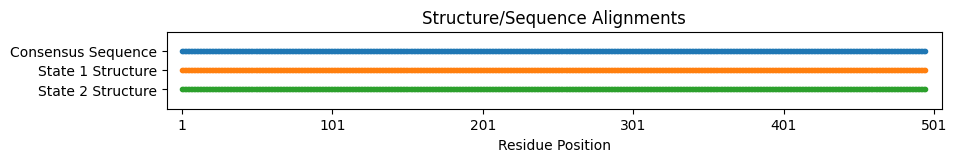

Mutation Statistics:
• Mutable positions: 495/495 AA positions (100.0%)
• Generated mutations: 9405/9405 possible point mutations (100.0%)



In [22]:
#@title Chain Configuration, Sequence Alignment, and Mutant Generation
#@markdown Select chains based on structures as shown above.
#@markdown This cell will extract sequences from those chains, and generate a consensus sequence that can be aligned to both structures.
#@markdown Please check alignment results and visualization to ensure good results.


#@markdown Consensus sequence will then be used to generate all single mutants for positions that are resolved in both structures.

#@markdown ### Specify State 1 Chain ID
state1_chain = "A" #@param {type:"string"}

#@markdown ### Specify State 2 Chain ID
state2_chain = "A" #@param {type:"string"}

#@markdown ### (Optional) Reference Protein Sequence
#@markdown Upload a reference sequence to use as a template for sequence alignment.
#@markdown Reference sequence should be a superset of the sequences in the uploaded structures.
sequence = "MRCVGISNRDFVEGLSATGWVDVVLEHGSCVTTMAKDKPTLDIELLKTEVTNPAILRKLCIEAKISNTTTDSRCPTQGEATLVEEQDTNFVCRRTFVDRGWGNGCGLFGKGSLITCAKFKCVTKLEGKIVQYENLKYSVIVTVHTGDQHQVGNETTEHGTTATITPQAPTSEIQLTDYGALTLDCSPRTGLDFNEMVLLTMKEKSWLVHKQWFLDLPLPWTSGASTSQETWNRQDLLVTFKTAHAKKQEVVVLGSQEGAMHTALTGATEIQTSGTTTIFAGHLKCRLKMDKLTLKGVSYVMCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCKIPFSSQDEKGVIQNGRLITANPIVTDKEKPVNIEAEPPFGESYIVVGAGEKALKLSWFKKGSSIGKMFEATARGARRMAILGDTAWDFGSIGGVFTSVGKLVHQIFGTAYGVLFSGVSWTMKIGIGILLTWLGLNSRSTSLSMTCIAVGMVTLYLGVMVQA" #@param {type:"string"}

if state1_chain not in state1_chains:
    raise ValueError(f"Chain {state1_chain} not found in {state1_path}. Available chains are {state1_chains}.")
if state2_chain not in state2_chains:
    raise ValueError(f"Chain {state2_chain} not found in {state2_path}. Available chains are {state2_chains}.")

pdbs = {
    "state1": state1_path,
    "state2": state2_path,
}

chains = {
    'state1': state1_chain,
    'state2': state2_chain,
}

# - Aligns sequences from both conformational states
# - Creates consensus sequence
# - Identifies mutable positions present in both structures
# - Generates all possible single-point mutations
# - Provides detailed statistics and visualization of alignments
# - Validates sequence coverage and alignment quality

#get pdb sequences and align them for input chains
seqs = {pdb: get_chain_seq(pdbs[pdb], chains[pdb]) for pdb in pdbs}
scoring_seqs = {pdb: get_chain_seq_for_scoring(pdbs[pdb], chains[pdb]) for pdb in pdbs}

if len(sequence) == 0:
    con_seq = make_consensus_sequence(list(seqs.values()))
else:
    con_seq = make_consensus_sequence([sequence] + list(seqs.values()))

aligner = setup_aligner()
alignments = {pdb: aligner.align(con_seq, seq)[0] for pdb, seq in scoring_seqs.items()}

mappings = {
    pdb: alignment_to_mapping(alignment, allow_mismatches = False) for pdb, alignment in alignments.items()
}

def print_sequence_with_index(s, n):
    """
    Splits the input string s into chunks of length n and prints each chunk
    annotated with its starting index (1-based).
    """
    # Split string into chunks
    if len(s) <= n:
        chunks = [s]
    else:
        chunks = [s[i : i + n] for i in range(0, len(s), n)]
    max_anno_len = len(str((len(chunks) - 1) * n + 1))
    for i, chunk in enumerate(chunks):
        anno_str = str(i * n + 1)
        if len(anno_str) < max_anno_len:
            anno_str += " " * (max_anno_len - len(anno_str))
        print(f"{anno_str} {chunk}")

# Print consensus sequence with index
display(HTML("""
<h3>Consensus Sequence Analysis</h3>
<p style="color: #666; margin-bottom: 10px;">The consensus sequence represents the common sequence derived from both conformational states.</p>
"""))
print(f"\033[1mConsensus Sequence\033[0m (Length: {len(con_seq)})")
print_sequence_with_index(con_seq, 50)
print()

# Display sequence statistics
display(HTML("""
<h3>Structure Coverage Statistics</h3>
<p style="color: #666; margin-bottom: 10px;">Analysis of amino acid positions in each conformational state structure.</p>
"""))
print("\033[1mPosition Statistics:\033[0m")
print(f"• State 1: {len(scoring_seqs['state1'])}/{len(seqs['state1'])} AAs resolved ({(len(scoring_seqs['state1'])/len(seqs['state1'])*100):.1f}%)")
print(f"• State 2: {len(scoring_seqs['state2'])}/{len(seqs['state2'])} AAs resolved ({(len(scoring_seqs['state2'])/len(seqs['state2'])*100):.1f}%)")
print()

# Visualize sequence alignments
display(HTML("""
<h3>Sequence Alignment Analysis</h3>
<p style="color: #666; margin-bottom: 10px;">Validation of structure alignments. Check for potential issues with structure selection or coverage.</p>
"""))
print("\033[1mAlignment Scores:\033[0m")
print(f"• State 1 → Consensus: {alignments['state1'].score:.1f}")
print(f"• State 2 → Consensus: {alignments['state2'].score:.1f}")
print()
print("\033[1;33mNote:\033[0m Poor alignments or negative scores may indicate incorrect structures or poor coverage.")
print("Thick line represents aligned regions.")

# Find positions present in all structures
positions_present = []
for i in range(len(con_seq)):
    if (i in mappings['state1']) and (i in mappings['state2']) and con_seq[i] in AA_ALPHABET:
        positions_present.append(i)

con_track = [i for i in range(len(con_seq)) if con_seq[i] in AA_ALPHABET]
state1_track = [i for i in con_track if i in mappings["state1"]]
state2_track = [i for i in con_track if i in mappings["state2"]]

plt.figure(figsize=(10, 1))
plt.plot(con_track, [1.25] * len(con_track), marker=".")
plt.plot(state1_track, [1] * len(state1_track), marker = ".")
plt.plot(state2_track, [0.75] * len(state2_track), marker = ".")
plt.ylim(0.5, 1.5)
test = plt.xticks()[1][0]

def parse_text(s):
    """helper to fix xtick labels"""
    if s[0].isnumeric():
        return int(s)
    else:
        return -1*int(s[1:])

plt.xticks(plt.xticks()[0], [parse_text(i.get_text()) + 1 for i in plt.xticks()[1]])
plt.xlim(-10, len(con_seq) + 10)
plt.yticks([0.75, 1, 1.25], ['State 2 Structure', 'State 1 Structure', 'Consensus Sequence'])
plt.xlabel("Residue Position")
plt.title('Structure/Sequence Alignments')
plt.show()

# Generate mutants and create dataframe
mutants = []
mutant_sequences = []
mutant_ids = []  # for simplifying workflow with uploaded sequences
for i in positions_present:
    aa = con_seq[i]
    for aa_new in AA_ALPHABET:
        if aa_new != aa:
            mutant_sequences.append(con_seq[:i] + aa_new + con_seq[i + 1 :])
            mutants.append(f"{aa}{i+1}{aa_new}")
            mutant_ids.append(f"SM-{aa}{i+1}{aa_new}")

display(HTML("""
<h3>Mutant Statistics</h3>
<p style="color: #666; margin-bottom: 10px;">Information about how many single mutant sequences were generated vs. total possible.</p>
"""))
# Print mutation statistics
print("\033[1mMutation Statistics:\033[0m")
print(f"• Mutable positions: {len(positions_present)}/{len(con_seq)} AA positions ({(len(positions_present)/len(con_seq)*100):.1f}%)")
print(f"• Generated mutations: {len(mutants)}/{len(con_seq) * 19} possible point mutations ({(len(mutants)/(len(con_seq) * 19)*100):.1f}%)")
print()

output = pd.DataFrame({'id': mutant_ids, 'mutant': mutants, 'sequence': mutant_sequences})

In [24]:
#@title Set CB run parameters and upload custom sequences
#@markdown ### Name CB Job
#@markdown Name will be used for file naming.

jobname = "CB-DEN-1" #@param {type:"string"}
#@markdown ---
#@markdown ### (Optional) Upload custom sequences for scoring
#@markdown If "yes", you will be prompted for file upload.
#@markdown Uploaded file should be in fasta format. Sequences should have the same length as the consensus sequence.
#@markdown Any sequences that are not accepted will raise an error and reset sequences to be scored to the previous state.
upload_custom_sequences = "no" # @param ["no","yes"]
#@markdown ---

from Bio import SeqIO

#uploader for custom sequences
def get_sequence_fasta(fasta_dir = './fasta_uploads/'):
    display(HTML(f"<h3>Upload Custom Fasta File</h3>"))
    upload_dict = files.upload()

    os.makedirs(fasta_dir, exist_ok = True)
    out_path = os.path.join(fasta_dir, rand_id() + '.fa')
    try:
        first_upload_key = [
            k
            for k in upload_dict
            if (k.endswith(".fa") or k.endswith(".fasta"))
        ][0]
        with open(out_path, "wb") as out:
            out.write(upload_dict[first_upload_key])

        for file in upload_dict:
            if os.path.exists(file):
                os.remove(file)
        return out_path
    except:
        for file in upload_dict:
            if os.path.exists(file):
                os.remove(file)
        raise FileNotFoundError("No fasta file uploaded! (extensions .fa and .fasta accepted)")

if upload_custom_sequences == "yes":
    new_output_rows = []
    fasta_fp = get_sequence_fasta()
    added_counter = 0
    invalid_inputs = []

    #consensus sequence may have some blank positions that are no scored
    con_seq_aa_positions = [i for i in range(len(con_seq)) if con_seq[i] in AA_ALPHABET]
    for record in SeqIO.parse(fasta_fp, "fasta"):
        id = record.id
        seq = record.seq

        #check for proper formatting
        if len(seq) != len(con_seq):
            print(f'Skipped {id} due to length mismatch - {len(seq)} vs. {len(con_seq)} (consensus).')
            invalid_inputs.append(id)
        elif not all(aas in AA_ALPHABET for aas in [seq[i] for i in con_seq_aa_positions]):
            print(f'Skipped {id} due to invalid characters in input sequence.')
            invalid_inputs.append(id)
        elif seq in set(output['sequence']):
            print(f'Skipped {id} due to sequence being already present sequences to be scored.')
        else:
            added_counter += 1

            id = id.replace(" ", "_")
            id = id.replace(",", "")
            if len(id) == 0:
                id = str(added_counter)
            cu_id = 'CU-' + id

            new_output_rows.append({'id': cu_id, 'mutant': None, 'sequence': seq})
            print(f'Listed {id} as {cu_id}.')

    if len(invalid_inputs) > 0:
        #do this to make sure user scores all sequences they want to
        print(f"\nReset sequences to previous state due to {len(invalid_inputs)} invalid input sequences in upload. Please fix and reupload. ")
    else:
        new_rows_df = pd.DataFrame(new_output_rows)
        output = pd.concat([output, new_rows_df], ignore_index = True)
        print(f"\nSuccessfully added {added_counter} new sequences to CB run.")

#throw an error if not all sequences added are added successfully - and reset output
#@markdown ### CB models to run
#@markdown Default: ProteinMPNN only. ESM-IF1 is slow comparatively, and ThermoMPNN will only score single mutants (no custom sequences).
run_proteinmpnn = "yes" # @param ["no","yes"]
run_frame2seq = "no" # @param ["no","yes"]
run_thermompnn = "no" # @param ["no","yes"]
run_esmif1 = "no" # @param ["no","yes"]
#@markdown ---
#@markdown #### **<font color='red'>WARNING: Re-running this code block will reset any previously generated model outputs!</font>**

model_outputs = {}

In [27]:
#@title Run CB Models

#@markdown Please ensure that you are running on a GPU-enabled runtime.
#@markdown For a protein of size ~38kDa/340 amino acids, model evaluation time for various GPUs is approximately:
#@markdown - **ProteinMPNN**: 3 min *(T4)*, 1 min *(L40)*, 1 min *(A100)*
#@markdown - **Frame2Seq**: &lt;1min *(T4, L40, A100)*
#@markdown - **ThermoMPNN**: &lt;1min *(T4, L40, A100)*
#@markdown - **ESM-IF1**: 1 hour *(T4)*, 30 min *(L40)*, 20 min *(A100)*

#@markdown If your execution is taking significantly longer, please open an issue with detailed description of your inputs on our github repository.


### PROTEINMPNN
if run_proteinmpnn == 'yes':
    #simple scoring function
    def mpnn_score(seq, model, return_indiv=False):
        '''use AR mask and seq to calculate PMPNN log likelihood'''
        L = len(seq)
        ar_mask = 1 - np.eye(L)
        outputs = model.score(seq=seq, ar_mask=ar_mask)
        pssm = softmax(outputs["logits"], -1)
        probs = np.squeeze(pssm[outputs["S"] == 1])

        if return_indiv:
            return np.log(probs)
        else:
            return np.log(probs).sum()

    print(f'Loading ProteinMPNN model...')
    homooligomer = False  # if structure is a homooligomer
    fix_pos = None
    inverse = True  # whether to invert the fix pos selection
    model_name = "v_48_020"  # ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]

    pmpnn_outputs = output.copy()

    if "mpnn_model" not in dir():
        mpnn_model = mk_mpnn_model(model_name)
    print(f'ProteinMPNN model loaded.\n')

    for structure in pdbs:
        print(f'Running ProteinMPNN on {structure}...')
        output_scores = []

        #load structure
        mpnn_model.prep_inputs(
            pdb_filename=pdbs[structure],
            chain=chains[structure],
            homooligomer=homooligomer,
            fix_pos=fix_pos,
            inverse=inverse,
            verbose=True,
        )

        #score wt
        wt_seq = mapping_to_sequence(con_seq, scoring_seqs[structure], mappings[structure])
        wt_score = mpnn_score(wt_seq, mpnn_model)

        #score all mut sequences
        for mut_seq in tqdm(pmpnn_outputs['sequence']):
            mapped_seq = mapping_to_sequence(mut_seq, scoring_seqs[structure], mappings[structure])
            score = mpnn_score(mapped_seq, mpnn_model)
            output_scores.append(score - wt_score)

        pmpnn_outputs["proteinmpnn_" + structure] = output_scores

    #scale variant scores and add bias values
    add_scaled_outputs(pmpnn_outputs, "proteinmpnn")
    model_outputs['proteinmpnn'] = pmpnn_outputs
    print('ProteinMPNN evaluation complete.')

### FRAME2SEQ
if run_frame2seq == 'yes':
    try:
        import frame2seq
    except:
        os.system("pip -q install git+https://github.com/andrewxue98/Frame2seq.git")

    from tqdm.notebook import tqdm
    import torch

    from frame2seq.utils import residue_constants
    from frame2seq.utils.util import get_neg_pll
    from frame2seq.utils.pdb2input import get_inference_inputs

    def frame2seq_score(
        runner,
        pdb_file: str,
        chain_id: str,
        input_seqs: list[str]
    ):
        """
        Calculates the pseudo-log-likelihood (PLL) scores for a list of input sequences
        given a structure using a Frame2seq model ensemble.

        Args:
            runner: Frame2seqRunner.
                An initialized Frame2seqRunner object containing the ensemble models.
            pdb_file: str
                Path to a PDB file containing the desired protein structure.
            chain_id: str
                Chain identifier (e.g., 'A') corresponding to the chain of interest in the PDB file.
            input_seqs: list of str
                List of amino acid sequences to be evaluated against the structure. Must be length matched.

        Returns:
            scores: list of float
                List of negative PLL scores, one for each input sequence. Higher (less negative)
                values indicate sequences more compatible with the structure.
        """
        # Get structure-based input tensors for inference
        seq_mask, backbone_seq_tokenized, X = get_inference_inputs(pdb_file, chain_id)

        # Decode backbone sequence from tokenized integer representation
        backbone_seq = [residue_constants.ID_TO_AA[int(i)] for i in backbone_seq_tokenized[0]]

        # Convert backbone sequence to one-hot encoding using standard AA to ID mapping
        backbone_seq_onehot = residue_constants.sequence_to_onehot(
            sequence=backbone_seq,
            mapping=residue_constants.AA_TO_ID,
        )

        # Convert one-hot numpy array to torch tensor and move to runner device
        backbone_seq_onehot = (
            torch.from_numpy(backbone_seq_onehot).float().unsqueeze(0).to(runner.device)
        )
        # Mask all positions in sequence by setting them to 'X' (unknown amino acid)
        backbone_seq_onehot = torch.zeros_like(backbone_seq_onehot)
        backbone_seq_onehot[:, :, 20] = 1  # 20 = 'X', mask all positions

        scores = []  # list to collect scores for each input sequence

        with torch.no_grad():
            # Run all three ensemble models to get amino acid probabilities
            aaprobs1 = runner.models[0].forward(X, seq_mask, backbone_seq_onehot)
            aaprobs2 = runner.models[1].forward(X, seq_mask, backbone_seq_onehot)
            aaprobs3 = runner.models[2].forward(X, seq_mask, backbone_seq_onehot)

            # Average logits from ensemble models
            aaprobs = (aaprobs1 + aaprobs2 + aaprobs3) / 3  # ensemble model predictions

            # Apply softmax to obtain amino acid probability distributions
            aaprobs = torch.nn.functional.softmax(aaprobs, dim=-1)

            # Only keep probabilities at valid sequence mask positions
            aaprobs = aaprobs[seq_mask]

            # Convert each input sequence to tensor of residue IDs on the runner device
            input_seqs = [
                torch.tensor([residue_constants.AA_TO_ID[aa] for aa in seq])
                .long()
                .to(runner.device)
                for seq in input_seqs
            ]

            # For each input sequence, calculate and collect the negative PLL score (log-likelihood under model)
            for sample in tqdm(range(len(input_seqs))):
                input_seq_i = input_seqs[sample]
                _neg_pll, avg_neg_pll = get_neg_pll(aaprobs, input_seq_i)
                scores.append(-1 * avg_neg_pll)  # multiply by -1 to return PLL

        return scores  # return list of scores, one per input sequence

    from frame2seq import Frame2seqRunner
    runner = Frame2seqRunner()

    print(f'Loading frame2seq model...')
    print(f'frame2seq model loaded.\n')

    #align seqs and generate mappings, as before
    f2s_seqs = {structure: "".join([residue_constants.ID_TO_AA[int(i)] for i in get_inference_inputs(pdbs[structure], chains[structure])[1].squeeze()]) for structure in pdbs}

    aligner = setup_aligner()
    f2s_alignments = {pdb: aligner.align(con_seq, seq)[0] for pdb, seq in f2s_seqs.items()}

    f2s_mappings = {
        pdb: alignment_to_mapping(alignment) for pdb, alignment in f2s_alignments.items()
    }

    f2s_outputs = output.copy()

    #evaluate sequences
    for structure in pdbs:
        print(f'Running frame2seq on {structure}...')
        output_seqs = []

        wt_seq = mapping_to_sequence(con_seq, f2s_seqs[structure], f2s_mappings[structure])
        wt_score = frame2seq_score(runner, pdbs[structure], chains[structure], [wt_seq])[0]

        for mut_seq in f2s_outputs['sequence']:
            mapped_seq = mapping_to_sequence(
                mut_seq, f2s_seqs[structure], f2s_mappings[structure]
            )
            output_seqs.append(mapped_seq)

        outs = frame2seq_score(runner, pdbs[structure], chains[structure], output_seqs)

        f2s_outputs[f"frame2seq_{structure}"] = [x - wt_score for x in outs]

    add_scaled_outputs(f2s_outputs, "frame2seq")
    model_outputs['frame2seq'] = f2s_outputs
    print('frame2seq evaluation complete.')

### THERMOMPNN
if run_thermompnn == 'yes':
    try:
        import thermompnn
    except:
        os.system("pip -q install git+https://github.com/andrewxue98/ThermoMPNN.git")
        os.system('wget "https://raw.githubusercontent.com/andrewxue98/ThermoMPNN/main/weights/thermoMPNN_default.pt"')
        os.system('wget "https://raw.githubusercontent.com/andrewxue98/ThermoMPNN/main/weights/v_48_020.pt"')

    from thermompnn.protein_mpnn_utils import alt_parse_PDB
    from thermompnn import Mutation, ALPHABET
    from thermompnn.analysis.thermompnn_benchmarking import load_model

    #generate sequences and mappings
    thermompnn_outputs = output.copy()

    thermompnn_seqs = {structure: alt_parse_PDB(pdbs[structure], chains[structure])[0]['seq'] for structure in pdbs}

    aligner = setup_aligner()
    thermompnn_alignments = {pdb: aligner.align(con_seq, seq)[0] for pdb, seq in thermompnn_seqs.items()}

    thermompnn_mappings = {
        pdb: alignment_to_mapping(alignment) for pdb, alignment in thermompnn_alignments.items()
    }

    print(f'Loading ThermoMPNN model...')
    model = load_model("v_48_020.pt", "thermoMPNN_default.pt")
    model = model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == "cpu":
        print("WARNING: GPU not available. ThermoMPNN requires GPU for optimal performance.")
        print("Consider using a GPU-enabled runtime or skipping ThermoMPNN.")
    model = model.to(device)
    print(f'ThermoMPNN model loaded.\n')

    for structure in pdbs:
        thermompnn_scores = []
        print(f'Running ThermoMPNN on {structure}...')

        pdb_fp = pdbs[structure]
        chain = chains[structure]

        mut_pdb = alt_parse_PDB(pdb_fp, chain)
        mutation_list = []

        #try to map mutants that we previously generated to thermompnn mutants (should be identical, but might slightly mismatch due to structure handling)
        for mut in thermompnn_outputs['mutant']:
            if mut is None:
                mutation_list.append(None)
            else: #only accepts single mutants, custom uploads are skipped
                wtAA, position, mutAA = str(mut[0]), int(str(mut[1:-1])), str(mut[-1])
                position = position - 1 #convert from 1-indexed to zero indexed

                if position in thermompnn_mappings[structure]:
                    position = thermompnn_mappings[structure][position]

                    assert (
                        wtAA in ALPHABET
                    ), f"Wild type residue {wtAA} invalid, please try again with one of the following options: {ALPHABET}"
                    assert (
                        mutAA in ALPHABET
                    ), f"Wild type residue {mutAA} invalid, please try again with one of the following options: {ALPHABET}"

                    #create thermompnn mutation objects
                    mutation_obj = Mutation(
                        position=position,
                        wildtype=wtAA,
                        mutation=mutAA,
                        ddG=None,
                        pdb=mut_pdb[0]["name"],
                    )
                    mutation_list.append(mutation_obj)
                else:
                    mutation_list.append(None)

        pred, _ = model(mut_pdb, mutation_list)

        for mut, out in zip(mutation_list, pred):
            if mut is not None:
                thermompnn_scores.append(-1 * out["ddG"].cpu().item())
            else:
                thermompnn_scores.append(None)

        thermompnn_outputs[f"thermompnn_{structure}"] = thermompnn_scores

    #add columns to output
    add_scaled_outputs(thermompnn_outputs, "thermompnn")
    model_outputs['thermompnn'] = thermompnn_outputs
    print('ThermoMPNN evaluation complete.')

if run_esmif1 == 'yes':
    try:
        import esm
    except:
        os.system("pip -q install git+https://github.com/andrewxue98/esm.git")
        os.system("pip -q install torch_geometric biotite")

    import torch
    import esm

    from esm.inverse_folding.util import CoordBatchConverter
    from scipy.special import softmax

    def get_esmif_aaprobs(model, alphabet, coords, seq):
        """
        Compute amino acid probabilities for a given sequence and structure using ESM-IF1.

        Args:
            model: The ESM-IF1 model.
            alphabet: The ESM alphabet object.
            coords: Numpy array of backbone coordinates for the structure.
            seq: Amino acid sequence (string).

        Returns:
            aa_probs: DataFrame of amino acid probabilities (rows: AAs, columns: positions).
        """
        # Get device from model
        device = next(model.parameters()).device

        # Prepare batch for the model
        batch_converter = CoordBatchConverter(alphabet)
        batch = [(coords, None, seq)]
        coords, confidence, strs, tokens, padding_mask = batch_converter(
            batch, device=device
        )

        # Prepare input tokens for the model
        prev_output_tokens = tokens[:, :-1].to(device)
        target = tokens[:, 1:]
        target_padding_mask = target == alphabet.padding_idx

        # Forward pass through the model
        logits, _ = model.forward(coords, padding_mask, confidence, prev_output_tokens)
        logits = logits.cpu().detach().numpy().squeeze()

        # Compute softmax probabilities and format as DataFrame
        aa_probs = pd.DataFrame(
            softmax(logits),
            index=list(alphabet.to_dict().keys())
        )
        # Restrict to standard amino acids
        aa_probs = aa_probs.loc[[aa for aa in AA_ALPHABET], :]
        # Normalize probabilities at each position
        aa_probs = aa_probs / aa_probs.sum(axis=0)

        return aa_probs


    def get_esmif_score(seq, model, alphabet, coords):
        """
        Compute the log-probability score of a sequence given structure using ESM-IF1.

        Args:
            seq: Amino acid sequence (string).
            model: The ESM-IF1 model.
            alphabet: The ESM alphabet object.
            coords: Numpy array of backbone coordinates for the structure.

        Returns:
            score: Log-probability score (float).
        """
        # Get amino acid probabilities for the sequence
        aa_probs = get_esmif_aaprobs(model, alphabet, coords, seq)
        score = 0.0
        # Sum log-probabilities for each residue in the sequence
        for idx, aa in enumerate(seq):
            score += np.log(aa_probs.loc[aa, idx])
        return score

    print(f'Loading ESM-IF1 model...')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
    model = model.to(device)
    model = model.eval()
    if device.type == "cpu":
        print("WARNING: GPU not available. ESM-IF1 will be very slow on CPU.")
    print(f'ESM-IF1 model loaded.\n')

    #load coordinates and sequences through esm package
    esm_seqs = {}
    esm_coords = {}
    for structure in pdbs:
        esm_structure = esm.inverse_folding.util.load_structure(pdbs[structure], chains[structure])
        coord, backbone_seq = esm.inverse_folding.util.extract_coords_from_structure(
            esm_structure
        )
        esm_seqs[structure] = backbone_seq
        esm_coords[structure] = coord

    aligner = setup_aligner()
    esm_alignments = {pdb: aligner.align(con_seq, seq)[0] for pdb, seq in esm_seqs.items()}

    esm_mappings = {
        pdb: alignment_to_mapping(alignment) for pdb, alignment in esm_alignments.items()
    }

    esm_outputs = output.copy()

    #score sequences
    for structure in pdbs:
        print(f'Running ESM-IF1 on {structure}...')
        output_scores = []

        wt_seq = mapping_to_sequence(con_seq, esm_seqs[structure], esm_mappings[structure])
        wt_score = get_esmif_score(wt_seq, model, alphabet, esm_coords[structure])

        for mut_seq in tqdm(esm_outputs['sequence']):
            mapped_seq = mapping_to_sequence(mut_seq, esm_seqs[structure], esm_mappings[structure])
            score = get_esmif_score(mapped_seq, model, alphabet, esm_coords[structure])
            output_scores.append(score - wt_score)

        esm_outputs["esmif1_" + structure] = output_scores

    #add to poutputs
    add_scaled_outputs(esm_outputs, "esmif1")
    model_outputs['esmif1'] = esm_outputs
    print('ESM-IF1 evaluation complete.')

#make sure at least one model was run
if len(model_outputs) == 0:
    raise ValueError('No CB models were run! Please enable at least one.')

#try and increment run counter - skip if fails
try:
    increment_cb_run_count()
except:
    pass

# Merge all model outputs
print("Merging results from all models...")

multimodel_output = output.copy()
for model in model_outputs:
    multimodel_output = pd.merge(multimodel_output, model_outputs[model], on=['id', 'mutant', 'sequence'], how='left')

display(HTML(f"<h3>CB Output Predictions</h3>"))
# Display summary statistics
print("\nFinal CB Output Summary:")
print(f"• Total variants analyzed: {len(multimodel_output):,}")
print(f"• Single-point mutations: {len(multimodel_output[multimodel_output['id'].str.startswith('SM-')]):,}")
print(f"• Custom sequences: {len(multimodel_output[multimodel_output['id'].str.startswith('CU-')]):,}")

# Show completion status for each model
print("\nModel Coverage:")
model_labels = {
    'proteinmpnn': 'ProteinMPNN',
    'frame2seq': 'Frame2Seq',
    'thermompnn': 'ThermoMPNN',
    'esmif1': 'ESM-IF1',
    'ensemble': 'Ensemble'
}
model_cols = {
    'proteinmpnn': ['proteinmpnn_state1', 'proteinmpnn_state2'],
    'frame2seq': ['frame2seq_state1', 'frame2seq_state2'],
    'thermompnn': ['thermompnn_state1', 'thermompnn_state2'],
    'esmif1': ['esmif1_state1', 'esmif1_state2']
}

for model in model_outputs:
    cols = model_cols[model]
    completed = multimodel_output[cols].notna().all(axis=1).sum()
    pct = (completed / len(multimodel_output)) * 100
    print(f"• {model_labels[model]} {completed:>6,}/{len(multimodel_output):<6,} sequences scored ({pct:>5.1f}%)")

#make ensemble predicti+ons across model
multimodel_output['ensemble_state1_scaled'] = multimodel_output[[f'{x}_state1_scaled' for x in model_outputs]].mean(axis=1)
multimodel_output['ensemble_state2_scaled'] = multimodel_output[[f'{x}_state2_scaled' for x in model_outputs]].mean(axis=1)

multimodel_output['ensemble_state1_bias'] = multimodel_output['ensemble_state1_scaled'] - multimodel_output['ensemble_state2_scaled']
multimodel_output['ensemble_state2_bias'] = multimodel_output['ensemble_state2_scaled'] - multimodel_output['ensemble_state1_scaled']

all_models = (list(model_outputs.keys())  + ['ensemble'])

for model in all_models:
    multimodel_output_copy = multimodel_output.copy().dropna(subset = [f'{model}_state1_bias']).sort_values(by = f'{model}_state1_bias', ascending = False)
    passing_mutants = multimodel_output_copy[(multimodel_output_copy[f'{model}_state1_scaled'] > 0) | (multimodel_output_copy[f'{model}_state2_scaled'] > 0)]
    nonpassing = multimodel_output_copy[~((multimodel_output_copy[f'{model}_state1_scaled'] > 0) | (multimodel_output_copy[f'{model}_state2_scaled'] > 0))]

    n_mutants_passing_filter = len(multimodel_output_copy[(multimodel_output_copy[f'{model}_state1_scaled'] > 0) | (multimodel_output_copy[f'{model}_state2_scaled'] > 0)])
    n_biased = round(0.025 * n_mutants_passing_filter)

    state1_biased, neutral, state2_biased = passing_mutants[:n_biased], passing_mutants[n_biased:-n_biased], passing_mutants[-n_biased:]

    s1_set, s2_set, neutral_set, nonpassing_set = set(state1_biased['mutant']), set(state2_biased['mutant']), set(neutral['mutant']), set(nonpassing['mutant'])

    assignments = []
    for m in multimodel_output['mutant']:
        if m in set(state1_biased['mutant']):
            assignment = 'state1'
        elif m in set(state2_biased['mutant']):
            assignment = 'state2'
        elif m in neutral_set:
            assignment = 'neutral'
        elif m in set(nonpassing['mutant']):
            assignment = 'low'
        else:
            assignment = None

        assignments.append(assignment)

    multimodel_output[f'{model}_assignment'] = assignments

Loading ProteinMPNN model...
ProteinMPNN model loaded.

Running ProteinMPNN on state1...


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
#@title CB Results & Analysis
#@markdown This code block will generate a CB plot (scatter plot of scaled State 1 vs. State 2 scores) and label bias predicted mutants.
#@markdown If state 1 and state 2 scores are highly correlated, it may be worth to check if the structures you uploaded are meaningfully different.
#@markdown Ensemble will give scaled scores averaged over all models run and may help to smooth out model-specific biases.

model_to_analyze = "proteinmpnn" # @param ["proteinmpnn","frame2seq","thermompnn","esmif1", "ensemble"]

cmap = {'state1': 'red', 'state2': 'blue', 'neutral': 'grey', 'low': 'grey'}

if model_to_analyze in all_models:
    passing = multimodel_output[multimodel_output[f'{model_to_analyze}_assignment'] != 'low']
    nonpassing = multimodel_output[multimodel_output[f'{model_to_analyze}_assignment'] == 'low']

    state1_cutoff = multimodel_output[multimodel_output[f'{model_to_analyze}_assignment'] == 'state1'][f'{model_to_analyze}_state1_bias'].min()
    state2_cutoff = multimodel_output[multimodel_output[f'{model_to_analyze}_assignment'] == 'state2'][f'{model_to_analyze}_state2_bias'].min()

    plt.figure(figsize = (10,10))
    plt.title('Conformational Design Mutants (Top 5% mutants)')

    plt.scatter(passing[f'{model_to_analyze}_state1_scaled'], passing[f'{model_to_analyze}_state2_scaled'], marker = 'o', alpha = 0.7, edgecolor = 'black', c=[cmap[x] for x in passing[f'{model_to_analyze}_assignment']])
    plt.scatter(nonpassing[f'{model_to_analyze}_state1_scaled'], nonpassing[f'{model_to_analyze}_state2_scaled'], marker = 'o', alpha = 0.25, edgecolor = 'black', c=[cmap[x] for x in nonpassing[f'{model_to_analyze}_assignment']])

    #set limits to be equal on both axes
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    umin, umax = min(xmin, ymin), max(xmax, ymax)
    plt.xlim(umin, umax)
    plt.ylim(umin, umax)

    plt.plot([umin, 0], [0,0], color = 'black')
    plt.plot([0, 0], [umin,0], color = 'black')

    plt.plot([-state2_cutoff, umax-state2_cutoff], [0, umax], color = 'black')
    plt.plot([0, umax], [-state1_cutoff, umax -state1_cutoff], color = 'black')

    plt.xlabel(f'State 1 {model_labels[model_to_analyze]} Score')
    plt.ylabel(f'State 2 {model_labels[model_to_analyze]} Score')

    text_offset = 0.1
    plt.text(umax - text_offset, umax - text_offset, 'Neutral Mutants', horizontalalignment = 'right', verticalalignment = 'top')
    plt.text(umax - text_offset, umin + text_offset, 'State 1 Bias Predicted Mutants', horizontalalignment = 'right', verticalalignment = 'bottom')
    plt.text(umin + text_offset, umax - text_offset, 'State 2 Bias Predicted Mutants', horizontalalignment = 'left', verticalalignment = 'top')
    plt.text(umin + text_offset, umin + text_offset, 'Low Scoring Mutants', horizontalalignment = 'left', verticalalignment = 'bottom')
else:
    display(HTML(f"""<h4><font color='red'>Results from model {model_to_analyze} were not found!</font></h4>"""))


In [ ]:
#@title Export Results
#@markdown Exports scored variants as a csv, including bias predictions.
from datetime import date

today = date.today()

output_filepath = f'{jobname}_{today.month}{today.day}{today.year}_cb_variants.csv'
multimodel_output.to_csv(output_filepath, index = False)
files.download(output_filepath)